In [1]:
import torch
import numpy as np
from torchvision import datasets
from torch import nn, optim
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler
import helper
from sklearn.model_selection import train_test_split

In [2]:
data_dir = 'wastedata'
transform = transforms.Compose([transforms.Resize(230),
                                 transforms.CenterCrop(275),
                                 transforms.ToTensor(),
                                transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])])
                                                                 

        
dataset = datasets.ImageFolder(data_dir, transform=transform)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=32, shuffle=True)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


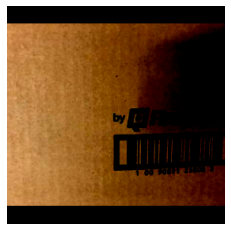

In [3]:
images, labels = next(iter(dataloader))
helper.imshow(images[0], normalize=False)

In [4]:
import splitfolders
input_folder ='wastedata'
output = "C:wastedatatestandtrain"
splitfolders.ratio(input_folder, output, seed=1337, ratio=(.8, .2), group_prefix=None)

Copying files: 4529 files [02:43, 27.76 files/s]


In [5]:
print(output)

C:wastedatatestandtrain


In [6]:
data_dir = 'wastedatatestandtrain'

train_transforms = transforms.Compose([transforms.RandomRotation(50),
                                       transforms.RandomResizedCrop(225),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.5, 0.5, 0.5], 
                                                            [0.5, 0.5, 0.5])])
test_transforms = transforms.Compose([transforms.RandomRotation(50), 
                                       transforms.RandomResizedCrop(225), 
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.5, 0.5, 0.5], 
                                                            [0.5, 0.5, 0.5])])
  

In [7]:
train_data = datasets.ImageFolder(data_dir + '\\train', transform=train_transforms)
test_data = datasets.ImageFolder(data_dir + '\\test', transform=test_transforms)

In [8]:
valid_size = 0.2
batch_size = 43

num_train = len(train_data)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split]

train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

train_loader = torch.utils.data.DataLoader(train_data, batch_size=43,
    sampler=train_sampler, num_workers=0)
valid_loader = torch.utils.data.DataLoader(train_data, batch_size=43, 
    sampler=valid_sampler, num_workers=0)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, 
    num_workers=0)

classes = ['food', 'glass', 'metal', 'plants', 'paper', 'plastic', 'wood']

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline


def imshow(img):
    img = img / 2 + 0.5  
    plt.imshow(np.transpose(img, (1, 2, 0)))  

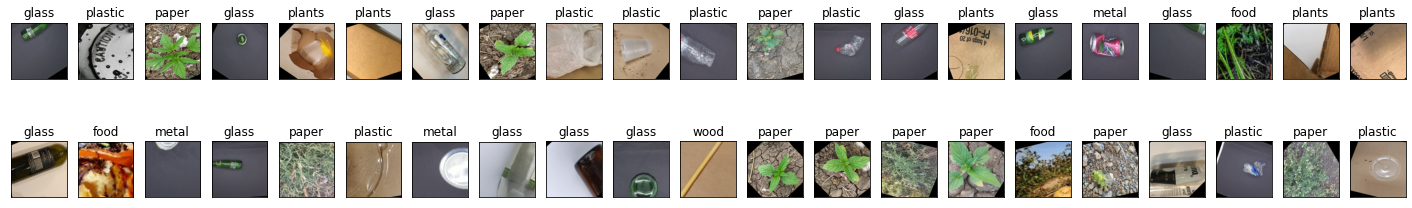

In [10]:
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy() 


fig = plt.figure(figsize=(25, 4))

for idx in np.arange(42):
    ax = fig.add_subplot(2, 42/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    ax.set_title(classes[labels[idx]])

In [11]:
import torch.nn.functional as F
class Network(nn.Module):
    def __init__(self):
        super(Network, self).__init__()
        # convolutional layer (sees 32x32x3 image tensor)
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)
        # convolutional layer (sees 16x16x16 tensor)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        # convolutional layer (sees 8x8x32 tensor)
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1)
        # max pooling layer
        self.pool = nn.MaxPool2d(2, 2)
        # linear layer (64 * 4 * 4 -> 500)
        self.fc1 = nn.Linear(64 * 28 * 28, 500)
        # linear layer (500 -> 10)
        self.fc2 = nn.Linear(500, 10)
        # dropout layer (p=0.25)
        self.dropout = nn.Dropout(0.25)
        
    def forward(self, x):
        # add sequence of convolutional and max pooling layers
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        
        # flatten image input
        x = x.view(x.size(0), -1)
        
        # add dropout layer
        x = self.dropout(x)
        # add 1st hidden layer, with relu activation function
        x = F.relu(self.fc1(x))
        # add dropout layer
        x = self.dropout(x)
        # add 2nd hidden layer, with relu activation function
        x = self.fc2(x)
        
        
        return x
       
model = Network()
print(model)


Network(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=50176, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=10, bias=True)
  (dropout): Dropout(p=0.25, inplace=False)
)


In [12]:
# specify loss function (categorical cross-entropy)
criterion = nn.CrossEntropyLoss()

# specify optimizer
optimizer = optim.SGD(model.parameters(), lr=0.01)

In [ ]:
# number of epochs to train the model
n_epochs = 15

valid_loss_min = np.Inf # track change in validation loss

for epoch in range(1, n_epochs+1):

    # keep track of training and validation loss
    train_loss = 0.0
    valid_loss = 0.0
    
    #Train the model
    model.train()
    for data, target in train_loader:
        #images = images.view(images.shape[0], -1)
        #images.resize_(images.size()[0], 784)
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update training loss
        train_loss += loss.item()*data.size(0)
        
        
    #Validate the model
    model.eval()
    for data, target in valid_loader:
         # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # update average validation loss 
        valid_loss += loss.item()*data.size(0)
    
    # calculate average losses
    train_loss = train_loss/len(train_loader.sampler)
    valid_loss = valid_loss/len(valid_loader.sampler)
    
     # print training/validation statistics 
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch, train_loss, valid_loss))
    
    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(model.state_dict(), 'model_cifar.pt')
        valid_loss_min = valid_loss

Epoch: 1 	Training Loss: 1.867507 	Validation Loss: 1.690964
Validation loss decreased (inf --> 1.690964).  Saving model ...
